In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [35]:
class anova:
    def __init__(self, df):
        self.df = df

    def oneway_anova(self):
        results = []

        # 각 그룹별로 데이터를 추출합니다.
        groups = self.df['group'].unique()
        group_data = [self.df[self.df['group'] == group]['value'] for group in groups]

        # 정규성 검정 (Shapiro-Wilk Test)
        normality = True
        for i, group in enumerate(groups):
            shapiro_test = stats.shapiro(group_data[i])
            results.append(f"Step1(Shapiro-Wilk for {group}) - Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")
            if shapiro_test.pvalue < 0.05:
                normality = False

        # 등분산성 검정 (Levene's Test)
        levene_test = stats.levene(*group_data)
        results.append(f"Step2(Levene's Test) - Statistic: {levene_test.statistic:.4f}, p-value: {levene_test.pvalue:.4f}")
        if levene_test.pvalue < 0.05:
            equal_variance = False
        else:
            equal_variance = True

        # ANOVA 수행 조건 확인
        if normality and equal_variance:
            # ANOVA 수행
            model = ols('value ~ C(group)', data=df).fit()
            anova_result = sm.stats.anova_lm(model, typ=2)
            results.append("----------\nPrior Test - Normality O / Equal Variance O\nResult(ANOVA):\n{}".format(anova_result))
        else:
            # Kruskal-Wallis H 검정 수행
            kruskal_test = stats.kruskal(*group_data)
            results.append("----------\nPrior Test - Normality X or Equal Variance X\nResult(Kruskal-Wallis H test) - Statistic: {:.4f}, p-value: {:.4f}".format(kruskal_test.statistic, kruskal_test.pvalue))
        
        return results
    
    def twoway_anova(self):
        results = []

        # 각 그룹별로 데이터를 추출합니다.
        groups1 = self.df['factor1'].unique()
        groups2 = self.df['factor2'].unique()
        
        # 각 조합별 데이터를 추출합니다.
        group_data = [self.df[(self.df['factor1'] == g1) & (self.df['factor2'] == g2)]['value'] for g1 in groups1 for g2 in groups2]
        
        # 정규성 검정 (Shapiro-Wilk Test)
        normality = True
        for data in group_data:
            shapiro_test = stats.shapiro(data)
            results.append(f"Shapiro-Wilk Test - Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")
            if shapiro_test.pvalue < 0.05:
                normality = False
        
        # 등분산성 검정 (Levene's Test)
        levene_test = stats.levene(*group_data)
        results.append(f"Levene's Test - Statistic: {levene_test.statistic:.4f}, p-value: {levene_test.pvalue:.4f}")
        if levene_test.pvalue < 0.05:
            equal_variance = False
        else:
            equal_variance = True

        # ANOVA 수행 조건 확인
        if normality and equal_variance:
            # Two-way ANOVA 수행
            model = ols('value ~ C(factor1) * C(factor2)', data=self.df).fit()
            anova_result = sm.stats.anova_lm(model, typ=2)
            results.append("----------\nPrior Test - Normality O / Equal Variance O\nResult(Two-way ANOVA):\n{}".format(anova_result))
        else:
            # Friedman Test 수행 (비모수적 대안)
            # 데이터를 넓은 형식으로 변환 (wide format)
            df_wide = self.df.pivot(index='factor1', columns='factor2', values='value')
            friedman_test = stats.friedmanchisquare(*[df_wide[col].dropna() for col in df_wide])
            results.append("----------\nPrior Test - Normality X or Equal Variance X\nResult(Friedman Test) - Statistic: {:.4f}, p-value: {:.4f}".format(friedman_test.statistic, friedman_test.pvalue))
        
        return results
    
    def anova_visualization(self):
        factor_cols = [col for col in self.df.columns if col != 'value']
        
        if len(factor_cols) == 1:
            factor = factor_cols[0]
            # 시각화
            plt.figure(figsize=(10, 6))
            sns.barplot(x=factor, y='value', data=self.df, ci='sd')
            plt.title('One-way ANOVA')
            plt.show()

        elif len(factor_cols) == 2:
            factor1 = factor_cols[0]
            factor2 = factor_cols[1]
            # 시각화 (선 그래프)
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=self.df, x=factor1, y='value', hue=factor2, marker='o')
            plt.title('Two-way ANOVA')
            plt.show()
        else:
            print("Error: The DataFrame should have either one or two factor columns.")

Shapiro-Wilk Test - Statistic: 0.9231, p-value: 0.4633
Shapiro-Wilk Test - Statistic: 1.0000, p-value: 1.0000
Shapiro-Wilk Test - Statistic: 0.9868, p-value: 0.7804
Shapiro-Wilk Test - Statistic: 1.0000, p-value: 1.0000
Shapiro-Wilk Test - Statistic: 1.0000, p-value: 1.0000
Shapiro-Wilk Test - Statistic: 0.9231, p-value: 0.4633
Levene's Test - Statistic: 0.7689, p-value: 0.5898
----------
Prior Test - Normality O / Equal Variance O
Result(Two-way ANOVA):
                          sum_sq    df           F        PR(>F)
C(factor1)             18.010000   2.0  174.290323  1.358542e-09
C(factor2)              0.055556   1.0    1.075269  3.202029e-01
C(factor1):C(factor2)   0.234444   2.0    2.268817  1.459645e-01
Residual                0.620000  12.0         NaN           NaN


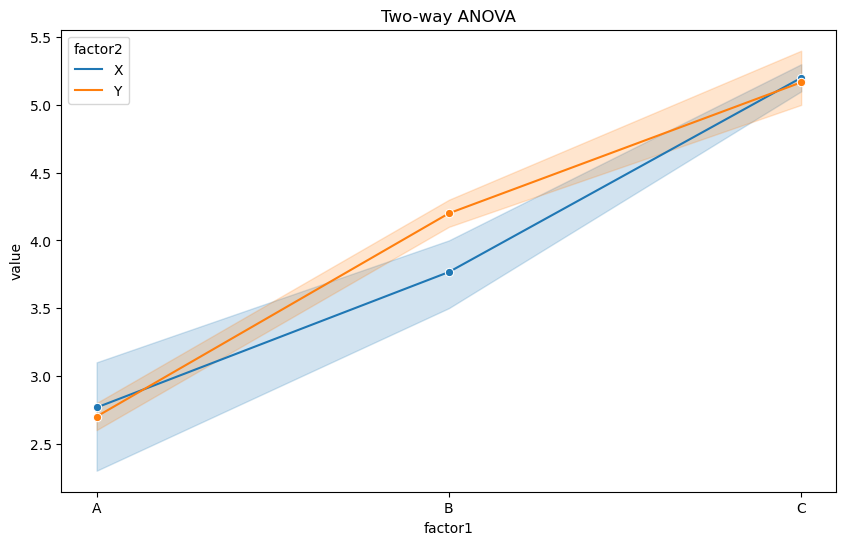

In [36]:
# 예시 데이터 (Two-way ANOVA)
data_twoway = {
    'factor1': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C'],
    'factor2': ['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y'],
    'value': [2.3, 3.1, 2.9, 3.8, 4.0, 3.5, 5.1, 5.3, 5.2, 2.6, 2.7, 2.8, 4.2, 4.1, 4.3, 5.0, 5.1, 5.4]
}
df_twoway = pd.DataFrame(data_twoway)

# Two-way ANOVA 시각화
test = anova(df_twoway)
results = test.twoway_anova()
# 각 단계의 결과를 여러 줄로 출력
for result in results:
    print(result)

test.anova_visualization()